# task 2

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import os
import random
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

from collections import Counter
from tqdm import notebook

from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM,GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

np.random.seed(5)

Using TensorFlow backend.


## Load data

In [2]:
# Load data
df_train = pd.read_csv('data/train.tsv',sep='\t')
df_test = pd.read_csv('data/test.tsv',sep='\t')

## Clean sentences

- nltk.tokenize.word_tokenize: 分词。句子级别，对一篇文档首先要将文章按句子进行分割，然后句子进行分词。
- lemmatizer.lemmatize: 词形还原。NLTK 中的词形还原功能依赖 WordNet 语料和一个名为 averaged_perceptron_tagger 的词性标注集

In [3]:
def clean_sentences(df):
    lemmatizer = WordNetLemmatizer()
    reviews = []

    for sent in notebook.tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent,'html.parser').get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)

    return reviews

In [4]:
# cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(df_train)
test_sentences = clean_sentences(df_test)

D:\Software\Anaconda\lib\site-packages\bs4\__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Software\Anaconda\lib\site-packages\bs4\__init__.py:314: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [5]:
# convert to one-hot encoded output
target = df_train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [6]:
# split into train and validation sets
X_train,X_val,y_train,y_val = train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [7]:
# Geting the no of unique words and max length of a review available in the list of cleaned reviews.
# It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in notebook.tqdm(X_train):
    unique_words.update(sent)
    len_max = max(len_max,len(sent))
        
#length of the list of unique_words gives the no of unique words
print('length of unique_words: ',len(list(unique_words)))
print('max length of sentence: ',len_max)


length of unique_words:  13731
max length of sentence:  48


- texts_to_sequences(texts)
    - Arguments - texts: list of texts to turn to sequences
    - Return: list of sequences (one per text input)

Output: [[1, 259],[1, 3400, 1808],[131, 46, 36, 77, 869, 2440],[164, 5, 582, 20, 62, 4376, 4181, 7207],...]

- pad_sequences
    - padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length. Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
    
Output:array([[0,0,0,...,0,1,259],
         [0,0,0,...,1,3400,1808],
         [0,0,0,...,77,869,2440],
         ...])

In [8]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

# texts to sequences

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

# pad sequences

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print('X_train.shape',X_train.shape)
print('X_val.shape',X_val.shape)
print('X_test.shape',X_test.shape)

X_train.shape (124848, 48)
X_val.shape (31212, 48)
X_test.shape (66292, 48)


- **Early stopping** is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.


In [9]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 2)
callback = [early_stopping]

- 嵌入层（Embedding Layer）是使用在模型第一层的一个网络层，其目的是将所有索引标号映射到致密的低维向量中，比如文本集[[4],[32],[67]]被映射为[[0.3,0.9,0.2],[-0.2,0.1,0,8],[0.1,0.3,0.9]]。该层通常用于文本数据建模。输入数据要求是一个二维张量：(1个批次内的文本数,每篇文本中的词语数)，输出为一个三维张量：(1个批次内的文本数, 每篇文本中的词语数,每个词语的维度)。

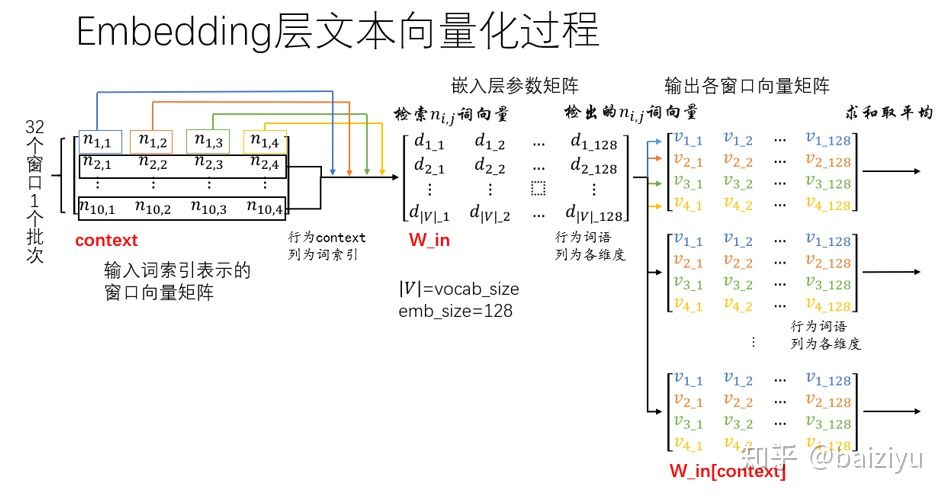

**input_dim**: 整数> 0。词汇表大小， i.e. maximum integer index + 1。

**output_dim**: 整数>= 0. 稠密嵌入矩阵的维度，也是词语向量的维度。

**input_length**: 当该值为常量时，表示一个文本词序列的长度。如果你在该层后要使用 Flatten 以及 Dense 层，该参数是必须设置的 (不设置该参数值,全连接层Dense输出形状无法计算)。

## CNN

In [10]:
top_words = len(list(unique_words))
embedding_vecor_length = 300

# create the model
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=len_max))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4119300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 64)            57664     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 32)            6176      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 32)            128       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [11]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

D:\Software\Anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 52s 413us/step - loss: 1.0557 - accuracy: 0.5775 - val_loss: 0.9049 - val_accuracy: 0.6357
Epoch 2/6
124848/124848 [==============================] - 52s 420us/step - loss: 0.8487 - accuracy: 0.6523 - val_loss: 0.8750 - val_accuracy: 0.6537
Epoch 3/6
124848/124848 [==============================] - 52s 418us/step - loss: 0.7732 - accuracy: 0.6788 - val_loss: 0.8500 - val_accuracy: 0.6526
Epoch 4/6
124848/124848 [==============================] - 53s 422us/step - loss: 0.7169 - accuracy: 0.6998 - val_loss: 0.8898 - val_accuracy: 0.6587
Epoch 5/6
124848/124848 [==============================] - 53s 424us/step - loss: 0.6776 - accuracy: 0.7117 - val_loss: 0.9020 - val_accuracy: 0.6620
Epoch 6/6
124848/124848 [==============================] - 54s 429us/step - loss: 0.6464 - accuracy: 0.7230 - val_loss: 0.9570 - val_accuracy: 0.6616


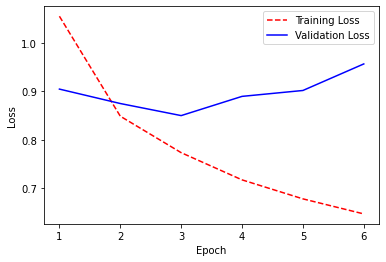

In [12]:
# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## RNN (LSTM)

In [13]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 2)
callback = [early_stopping]

In [14]:
model1=Sequential()
model1.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model1.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model1.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model1.add(Dense(100,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4119300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 4,395,361
Trainable params: 4,395,361
Non-trainable params: 0
____________________________________________

In [15]:
history1=model1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

D:\Software\Anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 234s 2ms/step - loss: 1.0334 - accuracy: 0.5829 - val_loss: 0.8486 - val_accuracy: 0.6522
Epoch 2/6
124848/124848 [==============================] - 241s 2ms/step - loss: 0.8229 - accuracy: 0.6627 - val_loss: 0.8032 - val_accuracy: 0.6653
Epoch 3/6
124848/124848 [==============================] - 250s 2ms/step - loss: 0.7572 - accuracy: 0.6882 - val_loss: 0.8100 - val_accuracy: 0.6743
Epoch 4/6
124848/124848 [==============================] - 247s 2ms/step - loss: 0.7189 - accuracy: 0.7015 - val_loss: 0.8082 - val_accuracy: 0.6768
Epoch 5/6
124848/124848 [==============================] - 244s 2ms/step - loss: 0.6937 - accuracy: 0.7104 - val_loss: 0.8082 - val_accuracy: 0.6747
Epoch 6/6
124848/124848 [==============================] - 243s 2ms/step - loss: 0.6761 - accuracy: 0.7171 - val_loss: 0.8354 - val_accuracy: 0.6747


## Test submission

In [16]:
y_pred = model.predict_classes(X_test)

sub_file = pd.read_csv('sampleSubmission.csv',sep=',')
sub_file.Sentiment = y_pred
sub_file.to_csv('Submission_cnn.csv',index=False)

In [17]:
y_pred1 = model1.predict_classes(X_test)

sub_file1 = pd.read_csv('sampleSubmission.csv',sep=',')
sub_file1.Sentiment = y_pred1
sub_file1.to_csv('Submission_rnn.csv',index=False)